In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bert-score pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load datasets
mayoclinic = pd.read_csv("/content/drive/MyDrive/P2/LLM/LLL-Advice/Advice/MayoClinic.csv")
medlineplus = pd.read_csv("/content/drive/MyDrive/P2/LLM/LLL-Advice/Advice/MedlinePlus.csv")
healthline = pd.read_csv("/content/drive/MyDrive/P2/LLM/LLL-Advice/Advice/Healthline.csv")

# Ensure columns are consistent
mayoclinic.columns = ['disease', 'cause']
medlineplus.columns = ['disease', 'cause']
healthline.columns = ['disease', 'cause']


# Align Data by Disease

In [4]:
# Merge datasets on 'disease'
merged_data = mayoclinic.merge(medlineplus, on="disease", suffixes=('_mayo', '_medline'))
merged_data = merged_data.merge(healthline, on="disease", suffixes=('', '_healthline'))

# Rename columns for clarity
merged_data = merged_data.rename(columns={"cause": "cause_healthline"})


# Calculate Semantic Similarity using BERTScore

In [5]:
from bert_score import score

# Initialize lists for similarity scores
similarity_mayo_medline = []
similarity_mayo_healthline = []
similarity_medline_healthline = []

# Compute BERTScore for each pair of causes
for index, row in merged_data.iterrows():
    cause_mayo = row["cause_mayo"]
    cause_medline = row["cause_medline"]
    cause_healthline = row["cause_healthline"]

    # Mayo vs Medline
    P, R, F1 = score([cause_mayo], [cause_medline], lang="en", verbose=False)
    similarity_mayo_medline.append(F1.mean().item())

    # Mayo vs Healthline
    P, R, F1 = score([cause_mayo], [cause_healthline], lang="en", verbose=False)
    similarity_mayo_healthline.append(F1.mean().item())

    # Medline vs Healthline
    P, R, F1 = score([cause_medline], [cause_healthline], lang="en", verbose=False)
    similarity_medline_healthline.append(F1.mean().item())

# Add similarity scores to the dataframe
merged_data["similarity_mayo_medline"] = similarity_mayo_medline
merged_data["similarity_mayo_healthline"] = similarity_mayo_healthline
merged_data["similarity_medline_healthline"] = similarity_medline_healthline


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

# Save and Analyze the results

In [6]:
# Save the results
merged_data.to_csv("/content/drive/MyDrive/P2/LLM/LLL-Advice/Advice/Comparison_Results.csv", index=False)

# Display the results
print(merged_data[["disease", "similarity_mayo_medline", "similarity_mayo_healthline", "similarity_medline_healthline"]])


                           disease  similarity_mayo_medline  \
0                         diabetes                 0.835363   
1                        pneumonia                 0.853244   
2                           asthma                 0.860205   
3                             gout                 0.873591   
4                          malaria                 0.844948   
5                         migraine                 0.842517   
6                     appendicitis                 0.869927   
7                         diarrhea                 0.842916   
8                    endometriosis                 0.852331   
9                         epilepsy                 0.846482   
10                        epilepsy                 0.846482   
11                        epilepsy                 0.891422   
12                        epilepsy                 0.891422   
13                           fever                 0.846616   
14                    fibromyalgia                 0.86

In [7]:
print(merged_data[["similarity_mayo_medline", "similarity_mayo_healthline", "similarity_medline_healthline"]].describe())

       similarity_mayo_medline  similarity_mayo_healthline  \
count                54.000000                   54.000000   
mean                  0.871184                    0.867134   
std                   0.036874                    0.038383   
min                   0.827470                    0.815970   
25%                   0.845331                    0.841415   
50%                   0.857406                    0.852647   
75%                   0.883245                    0.878692   
max                   0.972873                    0.962773   

       similarity_medline_healthline  
count                      54.000000  
mean                        0.863591  
std                         0.027582  
min                         0.830517  
25%                         0.846938  
50%                         0.855712  
75%                         0.867444  
max                         0.964176  


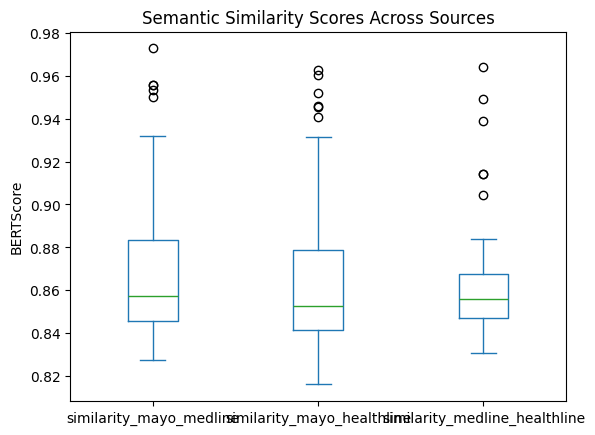

In [8]:
import matplotlib.pyplot as plt

# Boxplot of similarity scores
merged_data[["similarity_mayo_medline", "similarity_mayo_healthline", "similarity_medline_healthline"]].plot(kind='box')
plt.title("Semantic Similarity Scores Across Sources")
plt.ylabel("BERTScore")
plt.show()
